In [1]:
import pandas as pd
import numpy as np
import os
import glob
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [161]:
def preprocess_data(data, is_train=True):
    
    temp = data.copy()
    temp = temp[['Day','Hour','Minute', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]

    if is_train==True:          
    
        temp['Target1'] = temp['TARGET'].shift(-48).fillna(method='ffill')
        temp['Target2'] = temp['TARGET'].shift(-48*2).fillna(method='ffill')
        temp = temp.dropna()
        
        return temp.iloc[:-96]

    elif is_train==False:
        
        temp = temp[['Day','Hour','Minute', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T']]
                              
        return temp.iloc[-48:, :]

In [162]:
train = pd.read_csv('./data/train/train.csv')

test = []

for i in range(81):
    file_path = './data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp['Day'] = i
    temp = preprocess_data(temp, is_train=False)
    test.append(temp)

df_test = pd.concat(test)

submission = pd.read_csv('./data/sample_submission.csv')

In [4]:
df_train = preprocess_data(train)

df_train.shape, df_test.shape

((52464, 10), (3888, 8))

In [71]:
3888 - 1539

2349

In [ ]:
df_train.columns

In [72]:
df_train.drop(df_train[df_train.TARGET == 0].index, inplace=True)
df_test = df_test[df_test.TARGET > 0]

In [73]:
df_test.shape

(1539, 8)

In [9]:
df_train.WS = np.log1p(df_train.WS)
df_test.WS = np.log1p(df_test.WS)

In [10]:
min = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].min()
max  = df_train[['Day','Hour','DHI','DNI','WS','RH','T']].max()

In [11]:
for i, col in enumerate(['Day','Hour','DHI','DNI','WS','RH','T']):
    df_train[col] = (df_train[col] - min[i]) / (max[i] - min[i])
    df_test[col] = (df_test[col] - min[i]) / (max[i] - min[i])

In [12]:
Day0 = df_train.iloc[:, :-2]
Day  = df_train.iloc[:, 1:-2]
Day7 = df_train.iloc[:, -2]
Day8 = df_train.iloc[:, -1]
Day78 = df_train.iloc[:, -2:]

df_test0 = df_test.copy()
df_test = df_test.iloc[:, 1:]

In [13]:
def quantile_loss(q, y, pred):
    err = (y-pred)
    return mean(maximum(q*err, (q-1)*err), axis=-1)

In [14]:
q_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, Y_train, Y_valid = train_test_split(Day, Day78, test_size=0.25, random_state=42)

X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(Day, Day7, test_size=0.25, random_state=42)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(Day, Day8, test_size=0.25, random_state=42)

X_train.shape, X_valid.shape, Y_train.shape, Y_valid.shape

((19398, 7), (6466, 7), (19398, 2), (6466, 2))

In [16]:
import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras import layers
from tensorflow.keras.backend import mean, maximum

tf.random.set_seed(42)

epoch = 100

In [17]:
model = tf.keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(Day.shape)),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(2)
])

model.compile(loss='mse', optimizer='adam')
hist = model.fit(X_train, Y_train, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
model.evaluate(X_valid, Y_valid)

Epoch 1/100
304/304 [==============================] - 1s 3ms/step - loss: 941.2344 - val_loss: 367.3524
Epoch 2/100
304/304 [==============================] - 0s 1ms/step - loss: 349.7363 - val_loss: 334.3879
Epoch 3/100
304/304 [==============================] - 0s 1ms/step - loss: 314.5597 - val_loss: 320.5747
Epoch 4/100
304/304 [==============================] - 0s 1ms/step - loss: 301.6375 - val_loss: 321.5102
Epoch 5/100
304/304 [==============================] - 0s 1ms/step - loss: 306.0343 - val_loss: 321.7969
Epoch 6/100
304/304 [==============================] - 0s 1ms/step - loss: 303.3723 - val_loss: 307.7873
Epoch 7/100
304/304 [==============================] - 0s 1ms/step - loss: 293.2667 - val_loss: 302.8510
Epoch 8/100
304/304 [==============================] - 0s 1ms/step - loss: 290.2975 - val_loss: 317.6829
Epoch 9/100
304/304 [==============================] - 0s 1ms/step - loss: 292.9631 - val_loss: 308.8308
Epoch 10/100
304/304 [==============================] -

282.6980895996094

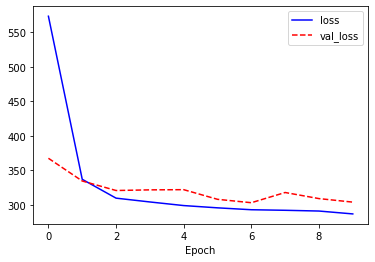

In [18]:
plt.plot(hist.history['loss'], 'b-', label='loss')
plt.plot(hist.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [19]:
results = pd.DataFrame()

for q in q_lst:
    model.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model.fit(Day, Day78, epochs=epoch, batch_size=48, validation_split=0.25, 
callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred = pd.DataFrame(model.predict(df_test))
    results = pd.concat([results, pred], axis=1)

results.shape

Epoch 1/100
405/405 [==============================] - 1s 1ms/step - loss: 3.1493 - val_loss: 3.1345
Epoch 2/100
405/405 [==============================] - 0s 1ms/step - loss: 2.9215 - val_loss: 3.1505
Epoch 3/100
405/405 [==============================] - 0s 1ms/step - loss: 2.8893 - val_loss: 3.1224
Epoch 4/100
405/405 [==============================] - 0s 1ms/step - loss: 2.9227 - val_loss: 3.1040
Epoch 5/100
405/405 [==============================] - 0s 1ms/step - loss: 2.8923 - val_loss: 3.1515
Epoch 6/100
405/405 [==============================] - 0s 1ms/step - loss: 2.8672 - val_loss: 3.1290
Epoch 7/100
405/405 [==============================] - 0s 1ms/step - loss: 2.8983 - val_loss: 3.1051
Epoch 00007: early stopping
Epoch 1/100
405/405 [==============================] - 1s 1ms/step - loss: 4.7178 - val_loss: 5.0708
Epoch 2/100
405/405 [==============================] - 0s 1ms/step - loss: 4.6516 - val_loss: 5.0458
Epoch 3/100
405/405 [==============================] - 1s 1ms/s

405/405 [==============================] - 1s 2ms/step - loss: 5.5139 - val_loss: 5.8740
Epoch 2/100
405/405 [==============================] - 1s 1ms/step - loss: 5.3789 - val_loss: 5.8966
Epoch 3/100
405/405 [==============================] - 1s 1ms/step - loss: 5.3967 - val_loss: 5.9175
Epoch 4/100
405/405 [==============================] - 1s 1ms/step - loss: 5.4992 - val_loss: 5.8597
Epoch 5/100
405/405 [==============================] - 1s 1ms/step - loss: 5.3748 - val_loss: 5.8732
Epoch 6/100
405/405 [==============================] - 1s 1ms/step - loss: 5.3766 - val_loss: 5.9986
Epoch 7/100
405/405 [==============================] - 1s 1ms/step - loss: 5.4199 - val_loss: 5.9326
Epoch 00007: early stopping
Epoch 1/100
405/405 [==============================] - 1s 2ms/step - loss: 4.8697 - val_loss: 5.2390
Epoch 2/100
405/405 [==============================] - 1s 1ms/step - loss: 4.7580 - val_loss: 5.2424
Epoch 3/100
405/405 [==============================] - 1s 1ms/step - loss: 

Epoch 2/100
405/405 [==============================] - 1s 1ms/step - loss: 1.5884 - val_loss: 1.7174
Epoch 3/100
405/405 [==============================] - 1s 1ms/step - loss: 1.5848 - val_loss: 1.7823
Epoch 4/100
405/405 [==============================] - 1s 1ms/step - loss: 1.6125 - val_loss: 1.7320
Epoch 5/100
405/405 [==============================] - 1s 1ms/step - loss: 1.5948 - val_loss: 1.8152
Epoch 00005: early stopping


(1539, 18)

In [20]:
results[1][:48]

,1,1,1,1,1,1,1,1,1
0,1.089914,1.535999,0.251481,2.067167,2.274558,2.980689,5.657227,7.501196,13.620013
1,2.454007,3.661700,3.207733,7.312933,6.125593,7.015919,13.943268,18.824673,28.100439
2,4.152181,5.272353,4.916296,10.437674,9.116087,10.385359,18.414761,23.743040,32.246162
3,7.645403,11.362823,11.982098,22.345695,21.396112,23.175467,32.208233,36.962116,49.590202
4,9.729984,14.176373,14.525365,24.343407,22.575294,25.448076,33.503662,36.404053,47.327972
5,13.925003,21.527153,20.120258,31.171200,29.313362,32.059452,40.228367,39.441025,42.437454
6,13.758869,23.006657,21.763710,32.858318,31.412830,34.656189,40.869354,39.015755,39.964523
7,16.477924,26.686825,24.446363,36.895210,35.948029,38.952061,50.046177,50.770226,59.937820
8,15.677671,24.338600,22.054665,34.716610,33.896721,36.820736,47.722492,48.221161,59.525246
9,15.143011,25.722069,24.011017,36.804966,34.961849,38.097794,45.701633,47.157135,59.947662


In [21]:
from lightgbm import LGBMRegressor

In [22]:
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
    
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,
                         n_estimators=10000, bagging_fraction=0.7, learning_rate=0.027, subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
          eval_set=[(X_valid, Y_valid)], early_stopping_rounds=300, verbose=500)

    # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in q_lst:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=q_lst
    
    return LGBM_models, LGBM_actual_pred

models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, df_test)
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, df_test)

0.1
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 2.74843
Early stopping, best iteration is:
[395]	valid_0's quantile: 2.74315
0.2
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 4.32907
[1000]	valid_0's quantile: 4.29785
[1500]	valid_0's quantile: 4.29175
[2000]	valid_0's quantile: 4.28777
[2500]	valid_0's quantile: 4.28681
Early stopping, best iteration is:
[2390]	valid_0's quantile: 4.28618
0.3
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 5.11035
[1000]	valid_0's quantile: 5.06385
[1500]	valid_0's quantile: 5.03819
[2000]	valid_0's quantile: 5.03241
[2500]	valid_0's quantile: 5.02522
[3000]	valid_0's quantile: 5.01099
[3500]	valid_0's quantile: 5.00274
[4000]	valid_0's quantile: 4.99971
Early stopping, best iteration is:
[3854]	valid_0's quantile: 4.99804
0.4
Training until validation scores don't improve for 300 rounds
[500]	valid_0's quantile: 5.3245
[1000]	

In [23]:
results_1[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,1.21,2.60,3.21,2.69,5.25,4.98,5.82,7.76,13.55
1,5.02,5.08,3.72,8.10,8.37,11.08,13.85,16.70,24.47
2,6.95,7.68,6.93,9.15,11.44,13.54,17.00,22.30,30.41
3,10.75,18.21,14.21,12.27,13.04,14.29,24.18,23.67,32.19
4,14.46,19.97,19.76,14.46,14.23,17.93,24.89,24.49,33.79
5,22.49,33.17,31.34,30.79,31.74,29.02,32.47,31.01,35.08
6,23.84,30.46,33.34,34.52,33.37,31.68,34.05,34.45,33.44
7,24.18,34.47,41.16,42.26,45.32,32.25,36.77,36.94,41.94
8,20.98,28.02,33.01,36.39,38.08,30.77,31.88,33.00,40.99
9,20.81,28.88,34.68,35.41,35.41,29.31,32.04,30.31,34.51


In [24]:
results_2[:48]

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.92,1.35,1.73,2.79,2.96,2.62,3.24,7.65,13.65
1,4.84,7.56,8.54,11.20,12.59,13.95,15.53,19.48,23.97
2,4.69,7.70,8.06,12.87,14.03,16.72,16.80,21.77,30.12
3,8.70,13.68,14.35,12.42,12.63,17.10,22.92,25.48,32.35
4,9.45,17.75,19.00,14.93,17.01,20.71,25.85,28.44,38.22
5,18.08,28.80,26.85,30.29,26.01,23.81,26.92,30.55,34.15
6,19.33,26.39,22.47,30.44,28.62,28.59,30.50,33.06,34.16
7,22.63,32.86,34.60,38.86,35.82,32.05,33.63,36.78,41.76
8,21.81,31.80,31.75,34.20,27.53,27.53,28.11,33.86,42.06
9,22.39,32.16,33.91,35.44,30.80,29.15,31.71,32.63,36.20


In [27]:
df_test.shape

(1539, 7)

In [28]:
model7 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model7.fit(np.array(Day).reshape(25864, 1, 7), np.array(Day7).reshape(25864, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred7 = np.squeeze(model7.predict(np.array(df_test).reshape(1539, 1, 7)))
    pred7 = pd.DataFrame(pred7)
    result7 = pd.concat([result7, pred7], axis=1)
    
result7[:48]

0.1
Epoch 1/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9777 - val_loss: 3.1102
Epoch 2/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9190 - val_loss: 3.1094
Epoch 3/100
405/405 [==============================] - 1s 2ms/step - loss: 2.8938 - val_loss: 3.1123
Epoch 4/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9480 - val_loss: 3.0977
Epoch 5/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9174 - val_loss: 3.1428
Epoch 6/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9016 - val_loss: 3.1273
Epoch 7/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9226 - val_loss: 3.1090
Epoch 8/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9014 - val_loss: 3.0722
Epoch 9/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9131 - val_loss: 3.1278
Epoch 10/100
405/405 [==============================] - 1s 1ms/step - loss: 2.9181 - va

405/405 [==============================] - 1s 2ms/step - loss: 3.8919 - val_loss: 4.2397
Epoch 2/100
405/405 [==============================] - 1s 2ms/step - loss: 3.8002 - val_loss: 4.1551
Epoch 3/100
405/405 [==============================] - 1s 2ms/step - loss: 3.8294 - val_loss: 4.2446
Epoch 4/100
405/405 [==============================] - 1s 2ms/step - loss: 3.8708 - val_loss: 4.1403
Epoch 5/100
405/405 [==============================] - 1s 2ms/step - loss: 3.7546 - val_loss: 4.2036
Epoch 6/100
405/405 [==============================] - 1s 2ms/step - loss: 3.7804 - val_loss: 4.1166
Epoch 7/100
405/405 [==============================] - 1s 2ms/step - loss: 3.7851 - val_loss: 4.1755
Epoch 8/100
405/405 [==============================] - 1s 2ms/step - loss: 3.8498 - val_loss: 4.1266
Epoch 9/100
405/405 [==============================] - 1s 2ms/step - loss: 3.7867 - val_loss: 4.1449
Epoch 10/100
405/405 [==============================] - 1s 2ms/step - loss: 3.8756 - val_loss: 4.2317
E

,0,0,0,0,0,0,0,0,0
0,0.348731,0.554478,0.771052,1.086361,1.878148,2.272291,4.032242,6.260856,10.634353
1,1.027880,1.711945,1.974530,2.487097,5.196687,5.665732,10.685476,16.257795,21.127674
2,2.203550,3.555515,3.431974,4.069526,8.909965,8.742459,13.262949,19.883142,25.723112
3,7.013263,12.216247,10.660323,10.378981,18.625441,17.626141,25.644768,34.888874,38.077370
4,9.103452,15.318599,13.829759,13.627136,21.281992,21.597427,25.956308,35.323227,37.067989
5,14.763417,25.196619,22.763470,22.808643,31.761524,34.103409,34.713825,42.633331,34.986988
6,16.758438,26.458612,23.757744,24.492601,33.554649,35.799686,36.333210,40.169979,33.962479
7,17.610710,30.811193,31.512955,29.265636,38.949345,41.157803,44.349277,50.931015,43.281418
8,15.310388,28.721195,29.501114,26.992758,37.178062,38.634224,42.145905,49.744267,41.529686
9,16.520775,29.376112,31.293385,29.964169,37.493893,38.847698,42.419136,48.186600,39.041752


In [29]:
model8 = tf.keras.Sequential([
    layers.Conv1D(filters=128, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=64, kernel_size=2, padding='same', activation='relu'),
    layers.Conv1D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.Dense(1)
])

result8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model8.fit(np.array(Day).reshape(25864, 1, 7), np.array(Day8).reshape(25864, 1), epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred8 = np.squeeze(model8.predict(np.array(df_test).reshape(1539, 1, 7)))
    pred8 = pd.DataFrame(pred8)
    result8 = pd.concat([result8, pred8], axis=1)
    
result8[:48]

0.1
Epoch 1/100
405/405 [==============================] - 1s 2ms/step - loss: 3.0383 - val_loss: 3.1890
Epoch 2/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9896 - val_loss: 3.2023
Epoch 3/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9669 - val_loss: 3.1825
Epoch 4/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9760 - val_loss: 3.2057
Epoch 5/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9567 - val_loss: 3.2585
Epoch 6/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9344 - val_loss: 3.1983
Epoch 7/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9774 - val_loss: 3.1679
Epoch 8/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9488 - val_loss: 3.1572
Epoch 9/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9534 - val_loss: 3.1603
Epoch 10/100
405/405 [==============================] - 1s 2ms/step - loss: 2.9556 - va

405/405 [==============================] - 1s 2ms/step - loss: 5.5383 - val_loss: 6.0416
Epoch 00006: early stopping
0.6
Epoch 1/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9668 - val_loss: 5.3480
Epoch 2/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9097 - val_loss: 5.3825
Epoch 3/100
405/405 [==============================] - 1s 2ms/step - loss: 4.8686 - val_loss: 5.3705
Epoch 4/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9875 - val_loss: 5.4243
Epoch 5/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9253 - val_loss: 5.3472
Epoch 6/100
405/405 [==============================] - 1s 2ms/step - loss: 4.8839 - val_loss: 5.3769
Epoch 7/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9309 - val_loss: 5.4808
Epoch 8/100
405/405 [==============================] - 1s 2ms/step - loss: 4.9588 - val_loss: 5.3431
Epoch 9/100
405/405 [==============================] - 1s 2ms/step - lo

,0,0,0,0,0,0,0,0,0
0,0.586329,1.294001,0.729435,1.448856,2.347870,3.072911,4.721885,6.036065,10.198798
1,1.068924,3.241029,1.287906,2.376184,3.148114,5.384584,10.104990,14.507016,18.551170
2,3.272756,6.562529,3.490634,5.614873,7.262458,11.227932,17.644110,21.233719,24.014761
3,9.428158,14.147050,12.573075,16.625309,20.459242,22.823587,30.048111,33.621944,35.424290
4,11.644973,15.683630,13.874595,19.249443,23.257790,23.785917,31.138536,33.246929,35.445709
5,17.078230,23.402231,21.986122,28.087221,32.493725,33.738998,36.425301,35.015198,35.553394
6,18.211073,25.141939,24.833261,30.900679,35.270168,35.799740,37.037495,35.834381,36.955414
7,20.067118,29.602354,30.755152,33.897537,40.410896,41.361565,44.548252,46.724224,49.580566
8,18.376162,26.669256,26.807775,30.494371,36.461365,37.668457,40.887398,42.695232,46.218060
9,19.786476,28.875738,29.869244,32.815174,38.795712,40.083305,42.444992,42.700863,45.866425


In [31]:
X_train_1.shape

(19398, 7)

In [32]:
model_G7 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[25864, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G7.fit(np.array(Day).reshape(25864, 1, 7), np.array(Day7).reshape(25864, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G7 = np.squeeze(model_G7.predict(np.array(df_test).reshape(1539, 1, 7)))
    pred_G7 = pd.DataFrame(pred_G7)
    result_G7 = pd.concat([result_G7, pred_G7], axis=1)
    
result_G7[:48]

0.1
Epoch 1/100
405/405 [==============================] - 4s 4ms/step - loss: 3.2318 - val_loss: 3.1680
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9927 - val_loss: 3.1225
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8983 - val_loss: 3.1044
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9248 - val_loss: 3.0849
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8982 - val_loss: 3.1094
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8805 - val_loss: 3.0775
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8912 - val_loss: 3.0977
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8760 - val_loss: 3.0638
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8942 - val_loss: 3.0689
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8833 - va

405/405 [==============================] - 1s 3ms/step - loss: 5.3324 - val_loss: 5.7550
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2515 - val_loss: 5.7583
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3934 - val_loss: 5.7357
Epoch 11/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2976 - val_loss: 5.8366
Epoch 12/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3184 - val_loss: 5.7649
Epoch 13/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2856 - val_loss: 5.7267
Epoch 14/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2526 - val_loss: 5.8994
Epoch 15/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3334 - val_loss: 5.7117
Epoch 16/100
405/405 [==============================] - 2s 4ms/step - loss: 5.3367 - val_loss: 5.7505
Epoch 17/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2266 - val_loss: 5

405/405 [==============================] - 1s 3ms/step - loss: 4.6121 - val_loss: 5.0716
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 4.7415 - val_loss: 5.0500
Epoch 00010: early stopping
0.7
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 3.8896 - val_loss: 4.1655
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 3.7880 - val_loss: 4.1622
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 3.8267 - val_loss: 4.2024
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 3.8939 - val_loss: 4.1590
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 3.7678 - val_loss: 4.1689
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 3.7814 - val_loss: 4.1833
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 3.7783 - val_loss: 4.1678
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - l

405/405 [==============================] - 1s 4ms/step - loss: 1.5448 - val_loss: 1.6766
Epoch 20/100
405/405 [==============================] - 1s 3ms/step - loss: 1.5223 - val_loss: 1.6800
Epoch 00020: early stopping


,0,0,0,0,0,0,0,0,0
0,0.121911,0.226862,0.534474,1.266406,1.198680,2.155460,3.967098,4.866168,9.765275
1,1.569337,3.137635,3.747150,5.324252,5.181961,6.430194,8.956088,11.151604,21.188997
2,3.182567,5.536314,5.541616,7.118532,7.107107,8.560990,12.548880,15.733072,27.756762
3,5.672319,10.510928,12.000305,15.141517,15.697982,18.082352,22.420256,27.264629,42.049759
4,8.302238,13.373036,13.624437,16.564363,17.613810,19.975491,24.753204,28.639999,41.642868
5,15.478213,21.569414,18.941748,22.939217,26.432163,31.043766,35.111755,34.749157,37.664337
6,17.519293,22.535355,19.508646,23.623806,28.605448,34.125328,37.456612,36.800533,38.413773
7,16.922230,26.200846,26.188810,30.728432,32.684372,38.773342,42.374115,41.599808,46.399887
8,14.194141,23.288677,26.246469,30.836456,31.255783,36.242390,39.390411,38.494053,45.065361
9,14.157064,24.299212,28.692219,31.761734,31.676521,37.316566,38.922333,37.411091,42.480476


In [33]:
model_G8 = tf.keras.Sequential([
    layers.GRU(units=64, return_sequences=True, input_shape=[25864, 7]),
    layers.GRU(units=32),
    layers.Dense(1)
])

result_G8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_G8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_G8.fit(np.array(Day).reshape(25864, 1, 7), np.array(Day7).reshape(25864, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, mode='min', monitor='val_loss', verbose=1)])
    pred_G8 = np.squeeze(model_G8.predict(np.array(df_test).reshape(1539, 1, 7)))
    pred_G8 = pd.DataFrame(pred_G8)
    result_G8 = pd.concat([result_G8, pred_G8], axis=1)
    
result_G8[:48]

0.1
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 3.2432 - val_loss: 3.1679
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9946 - val_loss: 3.1242
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8993 - val_loss: 3.1079
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9253 - val_loss: 3.0849
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8981 - val_loss: 3.1015
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8797 - val_loss: 3.0725
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8900 - val_loss: 3.0933
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8754 - val_loss: 3.0638
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8933 - val_loss: 3.0674
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8798 - va

405/405 [==============================] - 1s 3ms/step - loss: 4.4831 - val_loss: 4.9005
Epoch 31/100
405/405 [==============================] - 1s 3ms/step - loss: 4.4706 - val_loss: 4.8641
Epoch 32/100
405/405 [==============================] - 1s 3ms/step - loss: 4.4718 - val_loss: 4.8887
Epoch 33/100
405/405 [==============================] - 1s 3ms/step - loss: 4.4338 - val_loss: 4.8873
Epoch 00033: early stopping
0.3
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 5.3780 - val_loss: 5.7894
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2790 - val_loss: 5.7942
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2549 - val_loss: 5.7440
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3223 - val_loss: 5.7567
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 5.2190 - val_loss: 5.7193
Epoch 6/100
405/405 [==============================] - 1s 4ms/step -

405/405 [==============================] - 4s 5ms/step - loss: 4.7372 - val_loss: 5.0468
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6068 - val_loss: 5.0652
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6567 - val_loss: 5.0926
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 4.7156 - val_loss: 5.0579
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 4.5778 - val_loss: 5.0322
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 4.5940 - val_loss: 5.0792
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6078 - val_loss: 5.0900
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6953 - val_loss: 5.1087
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6006 - val_loss: 5.0633
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 4.7204 - val_loss: 5.0593
E

,0,0,0,0,0,0,0,0,0
0,-0.118148,0.728983,0.971046,1.047962,1.551056,1.912070,3.364514,3.760700,9.617659
1,1.108285,3.865702,5.232843,4.985348,5.321519,5.507869,8.577897,9.602978,20.866327
2,2.490887,5.952147,7.677533,7.011625,8.140335,7.945873,12.429950,13.378427,25.929480
3,4.716012,11.917788,16.408276,14.359765,15.824986,16.535480,23.286322,24.471409,38.971222
4,6.901226,13.708292,18.273079,15.512778,18.995520,19.388699,25.850063,25.775200,38.998653
5,12.192307,18.357838,26.428158,23.099239,30.649914,31.986101,36.528770,33.668385,36.662949
6,13.504175,17.855955,25.263275,25.149977,33.660610,35.402031,39.250977,36.593620,37.442463
7,13.584247,25.247437,36.553349,31.754292,35.200638,37.874706,42.947632,40.218739,46.160000
8,11.491407,24.585892,35.093590,30.945068,31.756310,33.964745,39.470657,36.203442,46.159149
9,11.213213,25.946133,34.889347,33.798912,32.327847,33.640877,38.528469,35.700878,43.475784


In [34]:
epoch = 100

model_M7 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[25864, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M7 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M7.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M7.fit(np.array(Day0).reshape(25864, 1, 8), np.array(Day7).reshape(25864, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M7 = np.squeeze(model_M7.predict(np.array(df_test0).reshape(1539, 1, 8)))
    pred_M7 = pd.DataFrame(pred_M7)
    result_M7 = pd.concat([result_M7, pred_M7], axis=1)
    
result_M7[:48]

0.1
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 3.2950 - val_loss: 3.1870
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 3.0158 - val_loss: 3.1502
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9102 - val_loss: 3.1094
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9287 - val_loss: 3.1227
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8959 - val_loss: 3.1331
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.8752 - val_loss: 3.1164
Epoch 00006: early stopping
0.2
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 4.9269 - val_loss: 5.1491
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 4.7902 - val_loss: 5.0797
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 4.6387 - val_loss: 5.0624
Epoch 4/100
405/405 [==============================] - 

0.5
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 5.5338 - val_loss: 5.8779
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3943 - val_loss: 5.9334
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 5.4051 - val_loss: 5.8108
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 5.4599 - val_loss: 5.8253
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3314 - val_loss: 5.8428
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 5.3258 - val_loss: 5.8512
Epoch 00006: early stopping
0.6
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 4.9576 - val_loss: 5.2184
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 4.8103 - val_loss: 5.1900
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 4.8532 - val_loss: 5.1591
Epoch 4/100
405/405 [==============================] - 

405/405 [==============================] - 5s 5ms/step - loss: 1.6102 - val_loss: 1.7036
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 1.5662 - val_loss: 1.7397
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6314 - val_loss: 1.7435
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6011 - val_loss: 1.8301
Epoch 00004: early stopping


,0,0,0,0,0,0,0,0,0
0,0.651626,1.412930,1.663878,2.391623,3.620630,3.022576,5.746896,6.427562,10.876079
1,1.516569,3.200346,5.007691,7.612739,10.807425,10.988094,16.742872,18.460148,25.416058
2,2.490597,5.195635,8.690712,12.623331,16.221693,14.467131,20.739613,22.330959,30.209188
3,3.558703,7.637560,13.491122,18.699293,23.502199,22.880861,31.975574,36.150452,46.415920
4,4.839878,10.198141,17.454243,22.693516,27.092474,24.169703,32.847008,36.482132,46.895279
5,7.798664,15.330933,24.164576,27.350012,31.454496,30.598495,36.305202,37.333523,40.848919
6,9.042477,16.690411,24.624172,27.018827,31.540594,32.735386,37.522675,38.003830,39.672966
7,8.000772,16.136662,27.386908,31.172380,36.419567,36.419098,43.420963,46.874535,51.689362
8,6.773403,14.348423,24.432497,28.812801,33.840446,33.451294,41.137058,45.712769,52.616653
9,6.526613,14.123219,23.619312,27.363253,32.228859,32.443634,38.739780,43.119469,48.208645


In [35]:
model_M8 = tf.keras.Sequential([
    layers.LSTM(units=64, return_sequences=True, input_shape=[25864, 8]),
    layers.LSTM(units=32),
    layers.Dense(1)
])

result_M8 = pd.DataFrame()

for q in q_lst:
    print(q)
    model_M8.compile(loss=lambda y,pred: quantile_loss(q,y,pred), optimizer='adam')
    model_M8.fit(np.array(Day0).reshape(25864, 1, 8), np.array(Day8).reshape(25864, 1)
                 , epochs=epoch, batch_size=48, validation_split=0.25, 
                callbacks = [tf.keras.callbacks.EarlyStopping(patience=3, mode='min', monitor='val_loss', verbose=1)])
    pred_M8 = np.squeeze(model_M8.predict(np.array(df_test0).reshape(1539, 1, 8)))
    pred_M8 = pd.DataFrame(pred_M8)
    result_M8 = pd.concat([result_M8, pred_M8], axis=1)
    
result_M8[:48]

0.1
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 3.2806 - val_loss: 3.2004
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 3.0349 - val_loss: 3.2131
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9744 - val_loss: 3.1773
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9478 - val_loss: 3.1986
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9357 - val_loss: 3.1754
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9037 - val_loss: 3.2504
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9439 - val_loss: 3.1595
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9168 - val_loss: 3.0943
Epoch 9/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9136 - val_loss: 3.1459
Epoch 10/100
405/405 [==============================] - 1s 3ms/step - loss: 2.9130 - va

405/405 [==============================] - 1s 3ms/step - loss: 5.9259 - val_loss: 6.3788
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 5.9295 - val_loss: 6.6669
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 5.9660 - val_loss: 6.3785
Epoch 00007: early stopping
0.5
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 5.8056 - val_loss: 6.1787
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 5.6966 - val_loss: 6.2135
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 5.6183 - val_loss: 6.1928
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 5.7152 - val_loss: 6.0725
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 5.6473 - val_loss: 6.1864
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 5.6345 - val_loss: 6.1753
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - lo

0.9
Epoch 1/100
405/405 [==============================] - 4s 5ms/step - loss: 1.6558 - val_loss: 1.7795
Epoch 2/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6320 - val_loss: 1.7602
Epoch 3/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6004 - val_loss: 1.7725
Epoch 4/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6337 - val_loss: 1.7847
Epoch 5/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6049 - val_loss: 1.7560
Epoch 6/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6030 - val_loss: 1.8209
Epoch 7/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6276 - val_loss: 1.7704
Epoch 8/100
405/405 [==============================] - 1s 3ms/step - loss: 1.6226 - val_loss: 1.7622
Epoch 00008: early stopping


,0,0,0,0,0,0,0,0,0
0,0.329373,1.272975,2.222000,3.875687,5.105513,5.777089,7.476045,10.104208,12.043563
1,1.128118,3.202078,5.518090,9.725550,12.969010,15.099604,18.141224,22.504183,24.998043
2,2.160001,5.547177,8.820875,13.377809,16.289724,18.242142,21.373890,25.896143,28.193527
3,3.460238,8.663424,13.986403,20.827868,26.041220,29.857420,33.051517,39.212105,41.550571
4,5.107563,11.910898,17.513607,23.314449,27.488192,30.451216,32.408348,37.889675,39.588684
5,8.993871,18.460552,25.109615,26.833054,30.154135,33.465408,32.359592,35.644203,35.074295
6,10.363093,19.981592,25.951077,25.325840,28.332447,33.150784,33.018898,35.123093,34.987961
7,9.228159,19.322693,28.750477,31.273363,37.178356,42.135048,40.336819,47.014378,47.310070
8,7.646490,16.922636,25.574295,30.638409,37.012051,41.465981,40.056301,47.252983,49.060436
9,7.260803,16.316357,25.232349,29.263187,35.237740,39.583549,37.688423,44.847450,47.182415


In [36]:
res_L0 = pd.DataFrame(results_1.sort_index())
res_L0.columns = ['L00.1','L00.2','L00.3','L00.4','L00.5','L00.6','L00.7','L00.8','L00.9']
res_L1 = pd.DataFrame(results_2.sort_index())
res_L1.columns = ['L10.1','L10.2','L10.3','L10.4','L10.5','L10.6','L10.7','L10.8','L10.9']

res_D0 = pd.DataFrame(results[0].sort_index())
res_D0.columns = ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9']
res_D1 = pd.DataFrame(results[1].sort_index())
res_D1.columns = ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9']

res_C0 = pd.DataFrame(result7.sort_index())
res_C0.columns = ['C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9']
res_C1 = pd.DataFrame(result8.sort_index())
res_C1.columns = ['C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9']

res_G0 = pd.DataFrame(result_G7.sort_index())
res_G0.columns = ['G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9']
res_G1 = pd.DataFrame(result_G8.sort_index())
res_G1.columns = ['G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9']

res_M0 = pd.DataFrame(result_M7.sort_index())
res_M0.columns = ['M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9']
res_M1 = pd.DataFrame(result_M8.sort_index())
res_M1.columns = ['M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9']

In [37]:
res_0 = pd.DataFrame()
res_1= pd.DataFrame()
res_0 = pd.concat([res_L0, res_D0, res_C0, res_G0, res_M0], axis=1)
res_1 = pd.concat([res_L1, res_D1, res_C1, res_G1, res_M1], axis=1)

In [38]:
res_0[:48]

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,1.21,2.60,3.21,2.69,5.25,4.98,5.82,7.76,13.55,0.907302,...,9.765275,0.651626,1.412930,1.663878,2.391623,3.620630,3.022576,5.746896,6.427562,10.876079
1,5.02,5.08,3.72,8.10,8.37,11.08,13.85,16.70,24.47,2.578902,...,21.188997,1.516569,3.200346,5.007691,7.612739,10.807425,10.988094,16.742872,18.460148,25.416058
2,6.95,7.68,6.93,9.15,11.44,13.54,17.00,22.30,30.41,3.995721,...,27.756762,2.490597,5.195635,8.690712,12.623331,16.221693,14.467131,20.739613,22.330959,30.209188
3,10.75,18.21,14.21,12.27,13.04,14.29,24.18,23.67,32.19,7.144335,...,42.049759,3.558703,7.637560,13.491122,18.699293,23.502199,22.880861,31.975574,36.150452,46.415920
4,14.46,19.97,19.76,14.46,14.23,17.93,24.89,24.49,33.79,9.069969,...,41.642868,4.839878,10.198141,17.454243,22.693516,27.092474,24.169703,32.847008,36.482132,46.895279
5,22.49,33.17,31.34,30.79,31.74,29.02,32.47,31.01,35.08,13.219215,...,37.664337,7.798664,15.330933,24.164576,27.350012,31.454496,30.598495,36.305202,37.333523,40.848919
6,23.84,30.46,33.34,34.52,33.37,31.68,34.05,34.45,33.44,13.704938,...,38.413773,9.042477,16.690411,24.624172,27.018827,31.540594,32.735386,37.522675,38.003830,39.672966
7,24.18,34.47,41.16,42.26,45.32,32.25,36.77,36.94,41.94,15.420390,...,46.399887,8.000772,16.136662,27.386908,31.172380,36.419567,36.419098,43.420963,46.874535,51.689362
8,20.98,28.02,33.01,36.39,38.08,30.77,31.88,33.00,40.99,14.241913,...,45.065361,6.773403,14.348423,24.432497,28.812801,33.840446,33.451294,41.137058,45.712769,52.616653
9,20.81,28.88,34.68,35.41,35.41,29.31,32.04,30.31,34.51,13.757400,...,42.480476,6.526613,14.123219,23.619312,27.363253,32.228859,32.443634,38.739780,43.119469,48.208645


In [39]:
res_1[:48]

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.92,1.35,1.73,2.79,2.96,2.62,3.24,7.65,13.65,1.089914,...,9.617659,0.329373,1.272975,2.222000,3.875687,5.105513,5.777089,7.476045,10.104208,12.043563
1,4.84,7.56,8.54,11.20,12.59,13.95,15.53,19.48,23.97,2.454007,...,20.866327,1.128118,3.202078,5.518090,9.725550,12.969010,15.099604,18.141224,22.504183,24.998043
2,4.69,7.70,8.06,12.87,14.03,16.72,16.80,21.77,30.12,4.152181,...,25.929480,2.160001,5.547177,8.820875,13.377809,16.289724,18.242142,21.373890,25.896143,28.193527
3,8.70,13.68,14.35,12.42,12.63,17.10,22.92,25.48,32.35,7.645403,...,38.971222,3.460238,8.663424,13.986403,20.827868,26.041220,29.857420,33.051517,39.212105,41.550571
4,9.45,17.75,19.00,14.93,17.01,20.71,25.85,28.44,38.22,9.729984,...,38.998653,5.107563,11.910898,17.513607,23.314449,27.488192,30.451216,32.408348,37.889675,39.588684
5,18.08,28.80,26.85,30.29,26.01,23.81,26.92,30.55,34.15,13.925003,...,36.662949,8.993871,18.460552,25.109615,26.833054,30.154135,33.465408,32.359592,35.644203,35.074295
6,19.33,26.39,22.47,30.44,28.62,28.59,30.50,33.06,34.16,13.758869,...,37.442463,10.363093,19.981592,25.951077,25.325840,28.332447,33.150784,33.018898,35.123093,34.987961
7,22.63,32.86,34.60,38.86,35.82,32.05,33.63,36.78,41.76,16.477924,...,46.160000,9.228159,19.322693,28.750477,31.273363,37.178356,42.135048,40.336819,47.014378,47.310070
8,21.81,31.80,31.75,34.20,27.53,27.53,28.11,33.86,42.06,15.677671,...,46.159149,7.646490,16.922636,25.574295,30.638409,37.012051,41.465981,40.056301,47.252983,49.060436
9,22.39,32.16,33.91,35.44,30.80,29.15,31.71,32.63,36.20,15.143011,...,43.475784,7.260803,16.316357,25.232349,29.263187,35.237740,39.583549,37.688423,44.847450,47.182415


In [40]:
res_0.loc[res_0[res_0['L00.1'] == 0].index, ['D00.1','D00.2','D00.3','D00.4','D00.5','D00.6','D00.7','D00.8','D00.9'
                                            ,'C00.1','C00.2','C00.3','C00.4','C00.5','C00.6','C00.7','C00.8','C00.9'
                                            ,'G00.1','G00.2','G00.3','G00.4','G00.5','G00.6','G00.7','G00.8','G00.9'
                                            ,'M00.1','M00.2','M00.3','M00.4','M00.5','M00.6','M00.7','M00.8','M00.9'
                                            ]] = 0
res_1.loc[res_1[res_1['L10.1'] == 0].index, ['D10.1','D10.2','D10.3','D10.4','D10.5','D10.6','D10.7','D10.8','D10.9'
                                            ,'C10.1','C10.2','C10.3','C10.4','C10.5','C10.6','C10.7','C10.8','C10.9'
                                            ,'G10.1','G10.2','G10.3','G10.4','G10.5','G10.6','G10.7','G10.8','G10.9'
                                            ,'M10.1','M10.2','M10.3','M10.4','M10.5','M10.6','M10.7','M10.8','M10.9'
                                            ]] = 0

In [41]:
res_0[:48]#.to_csv('0.csv', index=False)

,L00.1,L00.2,L00.3,L00.4,L00.5,L00.6,L00.7,L00.8,L00.9,D00.1,...,G00.9,M00.1,M00.2,M00.3,M00.4,M00.5,M00.6,M00.7,M00.8,M00.9
0,1.21,2.60,3.21,2.69,5.25,4.98,5.82,7.76,13.55,0.907302,...,9.765275,0.651626,1.412930,1.663878,2.391623,3.620630,3.022576,5.746896,6.427562,10.876079
1,5.02,5.08,3.72,8.10,8.37,11.08,13.85,16.70,24.47,2.578902,...,21.188997,1.516569,3.200346,5.007691,7.612739,10.807425,10.988094,16.742872,18.460148,25.416058
2,6.95,7.68,6.93,9.15,11.44,13.54,17.00,22.30,30.41,3.995721,...,27.756762,2.490597,5.195635,8.690712,12.623331,16.221693,14.467131,20.739613,22.330959,30.209188
3,10.75,18.21,14.21,12.27,13.04,14.29,24.18,23.67,32.19,7.144335,...,42.049759,3.558703,7.637560,13.491122,18.699293,23.502199,22.880861,31.975574,36.150452,46.415920
4,14.46,19.97,19.76,14.46,14.23,17.93,24.89,24.49,33.79,9.069969,...,41.642868,4.839878,10.198141,17.454243,22.693516,27.092474,24.169703,32.847008,36.482132,46.895279
5,22.49,33.17,31.34,30.79,31.74,29.02,32.47,31.01,35.08,13.219215,...,37.664337,7.798664,15.330933,24.164576,27.350012,31.454496,30.598495,36.305202,37.333523,40.848919
6,23.84,30.46,33.34,34.52,33.37,31.68,34.05,34.45,33.44,13.704938,...,38.413773,9.042477,16.690411,24.624172,27.018827,31.540594,32.735386,37.522675,38.003830,39.672966
7,24.18,34.47,41.16,42.26,45.32,32.25,36.77,36.94,41.94,15.420390,...,46.399887,8.000772,16.136662,27.386908,31.172380,36.419567,36.419098,43.420963,46.874535,51.689362
8,20.98,28.02,33.01,36.39,38.08,30.77,31.88,33.00,40.99,14.241913,...,45.065361,6.773403,14.348423,24.432497,28.812801,33.840446,33.451294,41.137058,45.712769,52.616653
9,20.81,28.88,34.68,35.41,35.41,29.31,32.04,30.31,34.51,13.757400,...,42.480476,6.526613,14.123219,23.619312,27.363253,32.228859,32.443634,38.739780,43.119469,48.208645


In [42]:
res_1[:48]#.to_csv('0.csv', index=False)

,L10.1,L10.2,L10.3,L10.4,L10.5,L10.6,L10.7,L10.8,L10.9,D10.1,...,G10.9,M10.1,M10.2,M10.3,M10.4,M10.5,M10.6,M10.7,M10.8,M10.9
0,0.92,1.35,1.73,2.79,2.96,2.62,3.24,7.65,13.65,1.089914,...,9.617659,0.329373,1.272975,2.222000,3.875687,5.105513,5.777089,7.476045,10.104208,12.043563
1,4.84,7.56,8.54,11.20,12.59,13.95,15.53,19.48,23.97,2.454007,...,20.866327,1.128118,3.202078,5.518090,9.725550,12.969010,15.099604,18.141224,22.504183,24.998043
2,4.69,7.70,8.06,12.87,14.03,16.72,16.80,21.77,30.12,4.152181,...,25.929480,2.160001,5.547177,8.820875,13.377809,16.289724,18.242142,21.373890,25.896143,28.193527
3,8.70,13.68,14.35,12.42,12.63,17.10,22.92,25.48,32.35,7.645403,...,38.971222,3.460238,8.663424,13.986403,20.827868,26.041220,29.857420,33.051517,39.212105,41.550571
4,9.45,17.75,19.00,14.93,17.01,20.71,25.85,28.44,38.22,9.729984,...,38.998653,5.107563,11.910898,17.513607,23.314449,27.488192,30.451216,32.408348,37.889675,39.588684
5,18.08,28.80,26.85,30.29,26.01,23.81,26.92,30.55,34.15,13.925003,...,36.662949,8.993871,18.460552,25.109615,26.833054,30.154135,33.465408,32.359592,35.644203,35.074295
6,19.33,26.39,22.47,30.44,28.62,28.59,30.50,33.06,34.16,13.758869,...,37.442463,10.363093,19.981592,25.951077,25.325840,28.332447,33.150784,33.018898,35.123093,34.987961
7,22.63,32.86,34.60,38.86,35.82,32.05,33.63,36.78,41.76,16.477924,...,46.160000,9.228159,19.322693,28.750477,31.273363,37.178356,42.135048,40.336819,47.014378,47.310070
8,21.81,31.80,31.75,34.20,27.53,27.53,28.11,33.86,42.06,15.677671,...,46.159149,7.646490,16.922636,25.574295,30.638409,37.012051,41.465981,40.056301,47.252983,49.060436
9,22.39,32.16,33.91,35.44,30.80,29.15,31.71,32.63,36.20,15.143011,...,43.475784,7.260803,16.316357,25.232349,29.263187,35.237740,39.583549,37.688423,44.847450,47.182415


In [43]:
for i in range(1, 10):
    res_0["L00."+str(i)] = (res_0["L00."+str(i)] + res_0["D00."+str(i)] + res_0["C00."+str(i)] + res_0["G00."+str(i)] + res_0["M00."+str(i)])/5
    res_1["L10."+str(i)] = (res_1["L10."+str(i)] + res_1["D10."+str(i)] + res_1["C10."+str(i)] + res_1["G10."+str(i)] + res_1["M10."+str(i)])/5

In [68]:
df_test[df_test.TARGET > 0]

,Day,Hour,TARGET,DHI,DNI,WS,RH,T
303,0,7,0.469267,5,0,4.5,68.92,-5.4
304,0,8,1.877069,20,0,5.0,63.50,-5.4
305,0,8,3.191010,34,0,5.3,62.54,-5.2
306,0,9,4.692657,50,1,5.6,61.26,-5.1
307,0,9,6.382006,66,7,5.8,60.80,-5.0
...,...,...,...,...,...,...,...,...
323,80,17,19.891246,130,244,1.7,32.01,20.6
324,80,18,12.666762,91,181,1.4,41.65,19.4
325,80,18,6.849547,54,126,1.2,45.74,17.9
326,80,19,2.251943,21,51,1.0,53.81,16.4


In [48]:
res_0.shape

(1539, 45)

In [57]:
df_test.columns

Index(['Day', 'Hour', 'TARGET', 'DHI', 'DNI', 'WS', 'RH', 'T'], dtype='object')

In [76]:
3078/2

1539.0

In [172]:
test0 = df_test[df_test.TARGET > 0][['Day', 'Hour', 'Minute']]
test0.shape

(2008, 3)

In [173]:
conc0 = pd.concat([test0[['Day', 'Hour', 'Minute']].reset_index(drop=True), res_0[['L00.1', 'L00.2', 'L00.3', 'L00.4', 'L00.5', 'L00.6', 'L00.7', 'L00.8','L00.9']].reset_index(drop=True)]
          , axis=1, ignore_index=True)

In [174]:
conc1 = pd.concat([test0[['Day', 'Hour', 'Minute']].reset_index(drop=True), res_1[['L10.1', 'L10.2', 'L10.3', 'L10.4', 'L10.5', 'L10.6', 'L10.7', 'L10.8','L10.9']].reset_index(drop=True)]
          , axis=1, ignore_index=True)

In [175]:
conc0.columns = ['Day', 'Hour', 'Minute','q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']
conc1.columns = ['Day', 'Hour', 'Minute','q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']

In [176]:
conc0.shape, df_test.shape, conc1.shape

((2008, 12), (3888, 9), (2008, 12))

In [178]:
conc0[:5]

,Day,Hour,Minute,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0,7,30,0.647914,1.196131,1.434812,1.876562,2.847241,3.010897,4.749901,6.106939,11.110855
1,0,8,0,2.342538,3.169679,3.466623,5.777014,6.937122,7.978345,12.368717,15.660684,23.320770
2,0,8,30,3.764487,5.131396,5.780598,8.174553,10.221474,10.855183,15.906742,20.214463,28.603241
3,0,9,0,6.827724,11.519275,12.081998,14.989933,17.776440,18.666013,26.654293,31.151393,41.051707
4,0,9,30,9.155107,14.038509,15.364830,17.498668,19.854481,21.263618,27.800950,31.694239,40.773613


In [179]:
test_sub = df_test[['Day', 'Hour', 'Minute']]
test_sub.shape

(3888, 3)

In [182]:
sub0 = test_sub.merge(conc0, on=['Day','Hour', 'Minute'], how='left').fillna(0)
sub1 = test_sub.merge(conc1, on=['Day','Hour', 'Minute'], how='left').fillna(0)

In [190]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = sub0[['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']].values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = sub1[['q_0.1', 'q_0.2', 'q_0.3', 'q_0.4', 'q_0.5', 'q_0.6', 'q_0.7','q_0.8', 'q_0.9']].values
submission[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [191]:
submission.to_csv('./submission/submission_20210124-2.csv', index=False)